<a href="https://colab.research.google.com/github/TaufiqIdrus/Python-Projects/blob/master/12_fold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Identifikasi Penyakit Pada Tanaman Apel menggunakan Convolutional Neural Network**

In [1]:
import numpy as np
import pickle
import os
import cv2
import tensorflow as tf
import keras
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from numpy import mean


Importing and Preparing Dataset

In [2]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive('/content/fold2.rar').extractall('/content/Datasets/')
iterasi = 2
width=60
height=60
default_image_size = tuple((height, width))
directory_root_train = '/content/Datasets/fold2/Train'
directory_root_validation = '/content/Datasets/fold2/Validation'
directory_root_test = '/content/Datasets/fold2/Test'
image_size = 0
depth=3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 5.9 MB/s 


In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return keras.preprocessing.image.img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Converting **Training** Data to Array

In [4]:
image_list_train, label_list_train = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root_train)

    for plant_disease_folder in root_dir:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{directory_root_train}/{plant_disease_folder}/")
      
        for image in plant_disease_image_list:
            image_directory = f"{directory_root_train}/{plant_disease_folder}/{image}"

            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list_train.append(convert_image_to_array(image_directory))
                label_list_train.append(plant_disease_folder)
    print("[INFO] Image loading completed")

except Exception as e:
    print(f"Error : {e}")

#image labeling
image_size = len(image_list_train)
label_binarizer = LabelBinarizer()
image_labels_train = label_binarizer.fit_transform(label_list_train)
pickle.dump(label_binarizer,open('label_transform_train.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
np_image_list_train = np.array(image_list_train, dtype=np.float16) / 255.0

[INFO] Loading images ...
[INFO] Processing apel_sehat ...
[INFO] Processing apel_bercak_daun ...
[INFO] Processing apel_cacar_daun ...
[INFO] Processing apel_busuk_buah ...
[INFO] Image loading completed


Converting **Validation** Data to Array

In [5]:
image_list_validation, label_list_validation = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root_validation)

    for plant_disease_folder in root_dir:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{directory_root_validation}/{plant_disease_folder}/")
      
        for image in plant_disease_image_list:
            image_directory = f"{directory_root_validation}/{plant_disease_folder}/{image}"

            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list_validation.append(convert_image_to_array(image_directory))
                label_list_validation.append(plant_disease_folder)
    print("[INFO] Image loading completed")

except Exception as e:
    print(f"Error : {e}")

#image labeling
image_size = len(image_list_validation)
label_binarizer = LabelBinarizer()
image_labels_validation = label_binarizer.fit_transform(label_list_validation)
pickle.dump(label_binarizer,open('label_transform_validation.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
np_image_list_validation = np.array(image_list_validation, dtype=np.float16) / 255.0

[INFO] Loading images ...
[INFO] Processing apel_sehat ...
[INFO] Processing apel_bercak_daun ...
[INFO] Processing apel_cacar_daun ...
[INFO] Processing apel_busuk_buah ...
[INFO] Image loading completed


Converting **Testing** Data to Array

In [6]:
image_list_test, label_list_test = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root_test)

    for plant_disease_folder in root_dir:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{directory_root_test}/{plant_disease_folder}/")
      
        for image in plant_disease_image_list:
            image_directory = f"{directory_root_test}/{plant_disease_folder}/{image}"

            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list_test.append(convert_image_to_array(image_directory))
                label_list_test.append(plant_disease_folder)
    print("[INFO] Image loading completed")

except Exception as e:
    print(f"Error : {e}")

#image labeling
image_size = len(image_list_test)
label_binarizer = LabelBinarizer()
image_labels_test = label_binarizer.fit_transform(label_list_test)
pickle.dump(label_binarizer,open('label_transform_test.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
np_image_list_test = np.array(image_list_test, dtype=np.float16) / 255.0

[INFO] Loading images ...
[INFO] Processing apel_sehat ...
[INFO] Processing apel_bercak_daun ...
[INFO] Processing apel_cacar_daun ...
[INFO] Processing apel_busuk_buah ...
[INFO] Image loading completed


Data Augmenting Initialization

In [7]:
aug = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode="nearest")

Creating CNN Model

In [8]:
model = keras.models.Sequential()
inputShape = (height, width, depth)

model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(50, (5, 5), padding="same"))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

model.add(Flatten())

model.add(Dense(500))
model.add(Activation("relu"))

model.add(Dense(4))
model.add(Activation("softmax"))

In [9]:
#model.summary()

In [10]:
#from PIL import Image
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
#display(Image.open('cnn_model.png'))

**Training** Network

In [11]:
EPOCHS = 200
INIT_LR = 1e-3
BS = 8

with tf.device('/GPU:0'):
  opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
  model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["Accuracy", "FalseNegatives", "FalsePositives", "TrueNegatives", "TruePositives"])
  
  history = model.fit(
      aug.flow(np_image_list_train, image_labels_train, batch_size=BS),
      validation_data=(np_image_list_validation, image_labels_validation),
      steps_per_epoch=len(np_image_list_train) // BS,
      epochs=EPOCHS, 
      verbose=1,
      )


Epoch 1/200
44/44 [==============================] - 18s 59ms/step - loss: 1.3805 - Accuracy: 0.4540 - false_negatives: 297.0000 - false_positives: 56.0000 - true_negatives: 988.0000 - true_positives: 51.0000 - val_loss: 1.2419 - val_Accuracy: 0.4545 - val_false_negatives: 48.0000 - val_false_positives: 48.0000 - val_true_negatives: 216.0000 - val_true_positives: 40.0000
Epoch 2/200
44/44 [==============================] - 1s 18ms/step - loss: 1.2178 - Accuracy: 0.4511 - false_negatives: 282.0000 - false_positives: 39.0000 - true_negatives: 1005.0000 - true_positives: 66.0000 - val_loss: 1.1337 - val_Accuracy: 0.4545 - val_false_negatives: 49.0000 - val_false_positives: 18.0000 - val_true_negatives: 246.0000 - val_true_positives: 39.0000
Epoch 3/200
44/44 [==============================] - 1s 18ms/step - loss: 1.1031 - Accuracy: 0.5776 - false_negatives: 239.0000 - false_positives: 45.0000 - true_negatives: 999.0000 - true_positives: 109.0000 - val_loss: 1.0022 - val_Accuracy: 0.6136 -

Plotting Traning Result

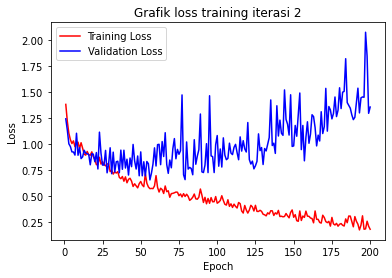

In [12]:
  #plotting
  epochs = range(1, len(history.history['loss'])+1)
  plt.title(f"Grafik loss training iterasi {iterasi}")
  plt.plot(epochs, history.history['loss'], 'r', label='Training Loss')
  plt.plot(epochs, history.history['val_loss'], 'b', label='Validation Loss')    
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()


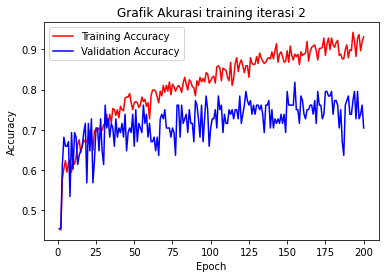

In [13]:
  #plotting
  epochs = range(1, len(history.history['loss'])+1)
  plt.title(f"Grafik Akurasi training iterasi {iterasi}")
  plt.plot(epochs, history.history['Accuracy'], 'r', label='Training Accuracy')
  plt.plot(epochs, history.history['val_Accuracy'], 'b', label='Validation Accuracy')    
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

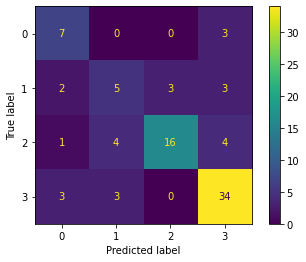

--------
[ 7  5 16 34]
[72 68 60 38]
[ 6  7  3 10]
[3 8 9 6]
--------
[0.89772727 0.82954545 0.86363636 0.81818182]
[0.7        0.38461538 0.64       0.85      ]
[0.92307692 0.90666667 0.95238095 0.79166667]
--------
62
238
26
26
--------
0.8522727272727273
0.7045454545454546
0.9015151515151515


In [14]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from numpy import mean
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, recall_score

validation = model.predict(np_image_list_validation)

predicted_labels = []
correct_labels = []
for i in range (len(validation)):
  predicted_labels.append(np.argmax(validation[i]))

for i in range (len(image_labels_validation)):
  correct_labels.append(np.argmax(image_labels_validation[i]))


confusion_matrix = confusion_matrix(correct_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)  
disp.plot()
plt.show()
print('--------')
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(TP)
print(TN)
print(FP)
print(FN)
print('--------')
print(ACC)
print(TPR)
print(TNR)
print('--------')

TP = sum(TP)
TN = sum(TN)
FP = sum(FP)
FN = sum(FN)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(TP)
print(TN)
print(FP)
print(FN)
print('--------')
print(ACC)
print(TPR)
print(TNR)

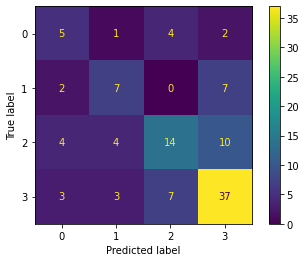

--------
[ 5  7 14 37]
[89 86 67 41]
[ 9  8 11 19]
[ 7  9 18 13]
--------
[0.85454545 0.84545455 0.73636364 0.70909091]
[0.41666667 0.4375     0.4375     0.74      ]
[0.90816327 0.91489362 0.85897436 0.68333333]
--------
63
283
47
47
--------
0.7863636363636364
0.5727272727272728
0.8575757575757575


In [15]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from numpy import mean
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, recall_score

test = model.predict(np_image_list_test)

predicted_labels = []
correct_labels = []
for i in range (len(test)):
  predicted_labels.append(np.argmax(test[i]))

for i in range (len(image_labels_test)):
  correct_labels.append(np.argmax(image_labels_test[i]))


confusion_matrix = confusion_matrix(correct_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)  
disp.plot()
plt.show()
print('--------')
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(TP)
print(TN)
print(FP)
print(FN)
print('--------')
print(ACC)
print(TPR)
print(TNR)
print('--------')

TP = sum(TP)
TN = sum(TN)
FP = sum(FP)
FN = sum(FN)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(TP)
print(TN)
print(FP)
print(FN)
print('--------')
print(ACC)
print(TPR)
print(TNR)

**Validating** Network

**Testing** Network

[[1.8221793e-03 1.9352235e-06 5.2206218e-03 9.9295539e-01]]
['apel_sehat']


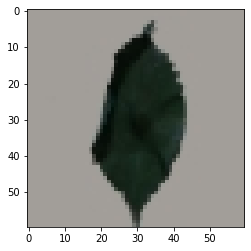

In [16]:
test_img = cv2.imread('/content/Datasets/fold2/Test/apel_sehat/apel_sehat (1).jpg')

plt.imshow(test_img)
test_img = test_img / 255
test_img = np.expand_dims(test_img, axis=0)
pr=model.predict(test_img)

print(pr)
output = label_binarizer.inverse_transform(pr)
print(output)

In [17]:
# save the model to disk
#print("[INFO] Saving model...")
#pickle.dump(model,open('cnn_model.pkl', 'wb'))
#model.save('/content/fold1.h5')